In [275]:
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
import numpy as np
import collections
from collections import Counter
import math
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [187]:
# columns to use
cols=['description', 'points']

# import data
reviews_1 = pd.read_csv('../../data/wine-reviews/winemag-data_first150k.csv', index_col=False, usecols=cols)
reviews_2 = pd.read_csv('../../data/wine-reviews/winemag-data-130k-v2.csv', index_col=False, usecols=cols)

print("Number of entries in dataset 1: %s" %reviews_1.shape[0])
print("Number of entries in dataset 2: %s" %reviews_2.shape[0])

duplicates = set(reviews_1.description).intersection(set(reviews_2.description))

print("\nNumber of duplicate entries across datasets: %s" % len(duplicates))

# concatenate and drop duplicates
data = pd.concat([reviews_1,reviews_2]).drop_duplicates().reset_index(drop=True)
data.drop_duplicates(inplace=True)

print("\nNumber of unique reviews: %s" % data.shape[0])

data.head()

Number of entries in dataset 1: 150930
Number of entries in dataset 2: 129971

Number of duplicate entries across datasets: 48346

Number of unique reviews: 169461


,description,points
0,This tremendous 100% varietal wine hails from ...,96
1,"Ripe aromas of fig, blackberry and cassis are ...",96
2,Mac Watson honors the memory of a wine once ma...,96
3,"This spent 20 months in 30% new French oak, an...",96
4,"This is the top wine from La Bégude, named aft...",95


In [189]:
def text_cleaning(data):

    # punctuation to remove
    punc_remove = string.punctuation
    punc_remove = punc_remove.replace('%', '')

    # stopwords to remove
    stop_words = stopwords.words('english')

    # lowercase
    data['description'] = data.description.str.lower()
    # remove punctuation
    data['description'] = data.description.str.replace('[' + punc_remove + ']', '')
    # replace percentage sign
    data['description'] = data.description.str.replace('%', ' percent')
    # replace underscores
    data['description'] = data.description.str.replace('_', ' ')
    # tokenize
    data['description'] = data['description'].apply(word_tokenize)
    # remove stop words
    data['description'] = data['description'].apply(lambda x: [word for word in x if word not in stop_words])
    # word stemming
    porter = PorterStemmer()
    data['description'] = data['description'].apply(lambda x: [porter.stem(word) for word in x])
    
    return data

data = text_cleaning(data)

data.head()

,description,points
0,"[tremend, 100, percent, variet, wine, hail, oa...",96
1,"[ripe, aroma, fig, blackberri, cassi, soften, ...",96
2,"[mac, watson, honor, memori, wine, made, mothe...",96
3,"[spent, 20, month, 30, percent, new, french, o...",96
4,"[top, wine, la, bégude, name, highest, point, ...",95


In [191]:
def create_vocabulary(documents):
    """Unique words and counts"""
    vocabulary = Counter()

    for row in documents:
        vocabulary.update(row)
        
    return vocabulary

documents = list(data.description)
vocabulary = create_vocabulary(documents)
vocabulary_size = len(vocabulary)

print("Number of unique words: %s" % vocabulary_size)

Number of unique words: 45426


In [192]:
def top_vocabulary(vocabulary, n_words=10000):
    """Limit vocabulary to highest occurring words and create IDs."""
    vocabulary_n = list(dict(vocabulary.most_common(n_words - 1)).keys())
    vocabulary_n.append('UNK') # placeholder for rare words
    
    vocabulary_n = dict(zip(vocabulary_n, random.sample(range(0, n_words+1), n_words)))
            
    return vocabulary_n

vocabulary_n = top_vocabulary(vocabulary)

In [193]:
def map_vocabulary(vocabulary, map_table):
    """Map vocabulary words to IDs"""
    vocabulary_map_table = dict.fromkeys(vocabulary.keys(), 0)
    for word in vocabulary:
        if word not in map_table:
            vocabulary_map_table[word] = map_table['UNK']
        else:
            vocabulary_map_table[word] = map_table[word]
            
    return vocabulary_map_table
    
vocabulary_map_table = map_vocabulary(vocabulary, vocabulary_n)

In [194]:
def map_documents(documents, vocabulary_map_table):
    """Map documents to integer word IDs"""
    documents_mapped = [[vocabulary_map_table[word] for word in doc] for doc in documents]
    
    return documents_mapped
    
documents_mapped = map_documents(documents, vocabulary_map_table)         

In [265]:
review_index = 0 # keep track of training batches
word_index = 0  # keep track of training batches
total_num_words = sum([len(doc) for doc in documents_mapped])

In [266]:
print("Total number of words in reviews: %d" % total_num_words)

Total number of words in reviews: 4246965


In [267]:
def generate_batch(documents_mapped, batch_size, num_skips, skip_window):
    
    global review_index
    global word_index
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # span considers window on both sides of target word
    # we could potentially consider a full sentence or review
    # as the context, but keeping it simpler for now
    span = 2 * skip_window + 1 
    
    # init buffer (context and target words)
    buffer = collections.deque(maxlen=span)
    
    # go back to first review if no more reviews left
    if review_index >= len(documents_mapped):
        review_index = 0
        word_index = 0
    
    # make sure there are enough words for skip-gram
    # could consider moving to next review instead of recycling words
    if word_index + span > len(documents_mapped[review_index]):
        word_index = max(len(documents_mapped[review_index]) - span - 1, 0)
    
    # new skip-gram
    buffer.extend(documents_mapped[review_index][word_index:word_index + span])
        
    for i in range(batch_size // num_skips):
        # skip_window is the same as index of target word
        context_words = [w for w in range(span) if w != skip_window]
        # randomly select context word indices to use
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            # target word
            batch[i * num_skips + j] = buffer[skip_window]
            # context word
            labels[i * num_skips + j, 0] = buffer[context_word]
        
        # add next words / new review for skips
        if word_index + span >= len(documents_mapped[review_index]):
            # next review
            if review_index < len(documents_mapped):
                review_index += 1
            # start at the beginning if non left
            else:
                review_index = 0
            
            word_index = 0
            buffer.extend(documents_mapped[review_index][word_index:word_index + span])
            word_index += span
        else:
            # add next word in review
            buffer.append(documents_mapped[review_index][word_index])
            word_index += 1
            
    return batch, labels
            
batch_size = 50
num_skips = 5
skip_window = 3
test_batch, test_labels = generate_batch(documents_mapped, batch_size, num_skips, skip_window)       

In [268]:
assert test_batch.shape[0] == batch_size

In [269]:
print("Target sample:")
print(test_batch[:10])
print("\nContext Sample:")
print(test_labels[:10])

Target sample:
[6397 6397 6397 6397 6397 6916 6916 6916 6916 6916]

Context Sample:
[[6916]
 [9922]
 [7573]
 [9228]
 [   6]
 [6397]
 [7573]
 [   6]
 [9922]
 [8678]]


In [270]:
embedding_size = 64

batch_size = 50
num_skips = 5
skip_window = 3

num_sampled = 32 # number of negative examples to sample

In [271]:
graph = tf.Graph()

with graph.as_default():
    
    # input data
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=batch_size) # target
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # context (what we want to predict)
        
    with tf.name_scope('embeddings'):
        # embedding weights
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # hidden layer weights
    with tf.name_scope('weights'):
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / math.sqrt(embedding_size)))
    # hidden layers biases
    with tf.name_scope('biases'):
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
    # NCE because softmax is too expensive
    # is it a good or a corrupt pair (context and target)?
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights, 
                biases=nce_biases, 
                labels=train_labels, 
                inputs=embed, 
                num_sampled=num_sampled, 
                num_classes=vocabulary_size))
        
    # for viz
    tf.summary.scalar('loss', loss)
    
    # SGD - minimize loss on train data (see loss above)
    # Learning Rate = 1.0 (don't care about overfitting)
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
#     valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid)

    # summary data
    merged = tf.summary.merge_all()
    
    # init variables
    init = tf.global_variables_initializer()
    
    # saver
    saver = tf.train.Saver()    

In [272]:
num_steps = 10001 # number of unique words

with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter('word2vec', session.graph)
    
    init.run()
    print('Initialized')
    
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(documents_mapped, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        run_metadata = tf.RunMetadata()
        
        _, summary, loss_val = session.run(
            [optimizer, merged, loss], 
            feed_dict=feed_dict, 
            run_metadata=run_metadata)
        
        average_loss += loss_val
        
        writer.add_summary(summary, step)
        
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)
            
        if step % 200 == 0:
            if step > 0:
                average_loss /= 200
                
            print('Average loss at step', step, ': ', average_loss)
        
    final_embeddings = normalized_embeddings.eval()

    saver.save(session, 'word2vec/model.ckpt')
    
writer.close()

Initialized
Average loss at step 0 :  157.68838500976562
Average loss at step 200 :  122.7402449798584
Average loss at step 400 :  99.4090491443634
Average loss at step 600 :  82.68935935552406
Average loss at step 800 :  74.02403318250455
Average loss at step 1000 :  66.45538460549534
Average loss at step 1200 :  64.2542045229344
Average loss at step 1400 :  61.004624036606984
Average loss at step 1600 :  56.87385280920891
Average loss at step 1800 :  53.684377386967036
Average loss at step 2000 :  50.21715144015749
Average loss at step 2200 :  48.09165140051134
Average loss at step 2400 :  44.236708154482564
Average loss at step 2600 :  45.41852344746492
Average loss at step 2800 :  43.909213614547006
Average loss at step 3000 :  41.3818800762896
Average loss at step 3200 :  38.54336080984056
Average loss at step 3400 :  37.481797124049855
Average loss at step 3600 :  37.03360638094496
Average loss at step 3800 :  35.458546922061466
Average loss at step 4000 :  34.951981736647355
Ave

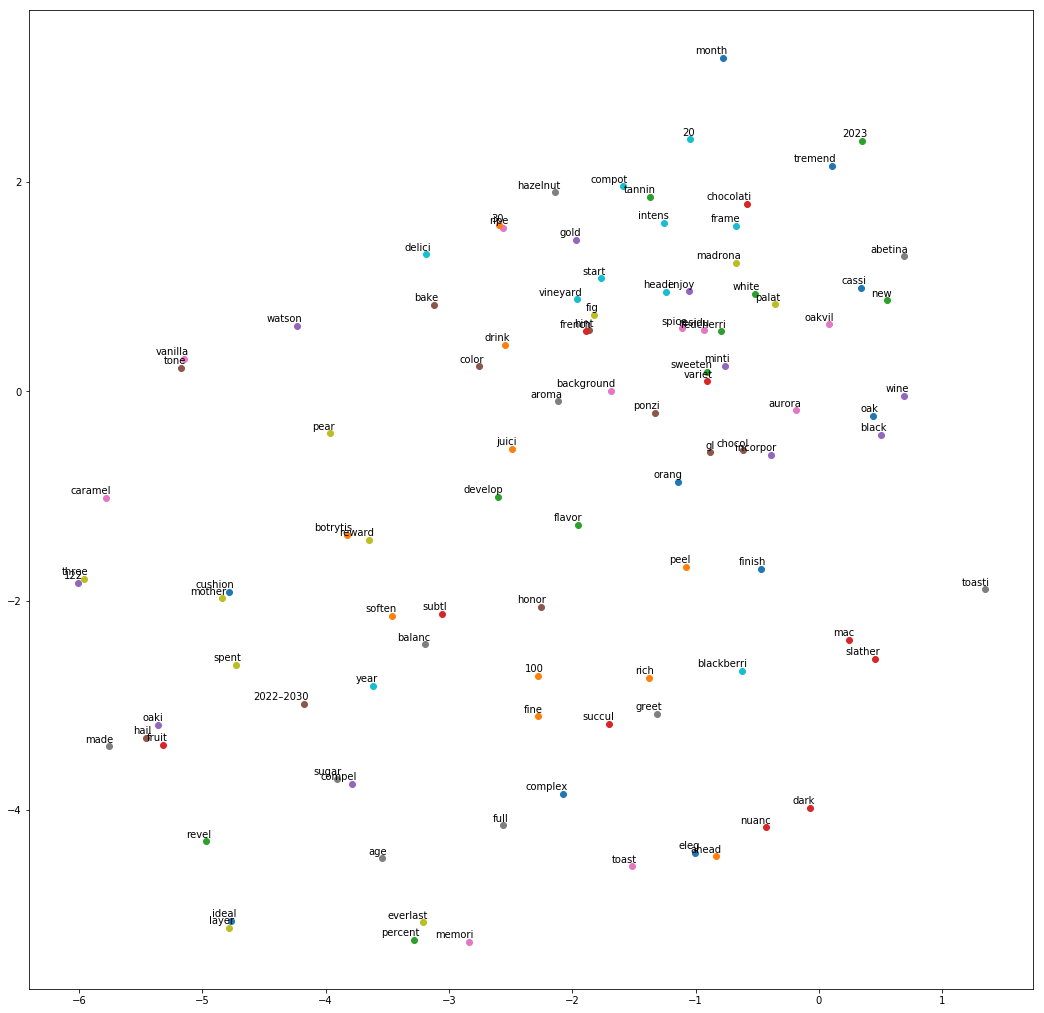

In [277]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 100
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [list(vocabulary_map_table.keys())[i] for i in range(plot_only)]

plt.figure(figsize=(18, 18))
for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

plt.show()

In [278]:
assert final_embeddings.shape[0] == len(vocabulary)

In [280]:
print("Longest review has %d words" % data.description.apply(len).max())
print("On average review has %d words" % data.description.apply(len).mean())

# restrict review length
print("95 percent quantile review number of words: %d" % data.description.apply(len).quantile(0.95))

Longest review has 83 words
On average review has 25 words
95 percent quantile review number of words: 38


In [24]:
max_review_length = 61

In [77]:
train_index = 0
# test_index = 0

def generate_train_batch(documents_mapped, output, batch_size):
    
    global train_index
    
    # pad with zeros if necessary
    batch = np.zeros(shape=(batch_size, max_review_length), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(train_index, batch_size):
        seq_len = min(len(documents_mapped[i]), max_review_length)
        batch[i, :seq_len] = documents_mapped[i][:seq_len]
        labels[i] = output[i]
        train_index += 1
        
        if train_index >= len(documents_mapped):
            train_index = 0
            
    return batch, labels


def generate_test_batch(documents_mapped, output):
    
#     global test_index
    batch_size = len(output)
    
    batch = np.zeros(shape=(batch_size, max_review_length), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        seq_len = min(len(documents_mapped[i]), max_review_length)
        batch[i, :seq_len] = documents_mapped[i][:seq_len]
        labels[i] = output[i]
#         test_index += 1
        
#         if test_index >= len(documents_mapped):
#             test_index = 0
            
    return batch, labels

In [78]:
from sklearn.model_selection import train_test_split

documents_mapped_train, documents_mapped_validate, points_train, points_validate = train_test_split(
    documents_mapped, 
    data.points.values, 
    test_size=0.2, 
    random_state=1234)

In [79]:
validation_X, validation_y = generate_test_batch(documents_mapped_validate, points_validate)

In [92]:
batch_size = 24
h_units = 64
learning_rate = 0.01

In [93]:
graph = tf.Graph()

with graph.as_default():
    
    # input data
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size, max_review_length]) # review
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # review points (predict)
        validation_inputs = tf.constant(validation_X)
        validation_labels = tf.constant(validation_y)
        
    with tf.name_scope('embeddings'):
        # embedding weights
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(final_embeddings, train_inputs)
    
    with tf.name_scope('LSTM_1'):
        lstmCell = tf.contrib.rnn.BasicLSTMCell(h_units)
        # drop out
        lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.9)
        # unroll
        value, _ = tf.nn.dynamic_rnn(lstmCell, embed, dtype=tf.float32)
    
    # output layer weights
    with tf.name_scope('weights'):
        output_weights = tf.Variable(tf.truncated_normal([h_units, 1],
                      stddev=1.0 / math.sqrt(embedding_size)))
    # output layers biases
    with tf.name_scope('bias'):
        output_bias = tf.Variable(tf.zeros([1]))
        
    value = tf.transpose(value, [1, 0, 2])
    last = tf.gather(value, int(value.get_shape()[0]) - 1)
    
    predictions = tf.add(tf.matmul(last, output_weights), output_bias)
    
    # validation
    validation_embed = tf.nn.embedding_lookup(final_embeddings, validation_inputs)
    validation_value, _ = tf.nn.dynamic_rnn(lstmCell, 
                                               validation_embed, 
                                               dtype=tf.float32)
    validation_value = tf.transpose(validation_value, [1, 0, 2])
    validation_last = tf.gather(validation_value, int(validation_value.get_shape()[0]) - 1)
    validation_predictions = tf.add(tf.matmul(validation_last, output_weights), output_bias)
    
    # MSE since linear output
    with tf.name_scope('loss'):
        loss = tf.losses.mean_squared_error(
            labels=train_labels, 
            predictions=predictions)
        
        validation_loss = tf.losses.mean_squared_error(
            labels=validation_labels, 
            predictions=validation_predictions)
        
    # for viz
    tf.summary.scalar('loss', loss)
    
    # SGD - minimize loss on train data (see loss above)
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # summary data
    merged = tf.summary.merge_all()
    
    # init variables
    init = tf.global_variables_initializer()
    
    # saver
    saver = tf.train.Saver()

In [95]:
num_steps = 50001

tf.reset_default_graph()

with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter('lstm', session.graph)
    
    init.run()
    print('Initialized')
    
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_train_batch(documents_mapped_train, points_train, batch_size)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        run_metadata = tf.RunMetadata()
        
        _, summary, loss_val = session.run(
            [optimizer, merged, loss], 
            feed_dict=feed_dict, 
            run_metadata=run_metadata)
        
        average_loss += loss_val
        
        writer.add_summary(summary, step)
        
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)
            
        if step % 200 == 0:
            if step > 0:
                average_loss /= 200
                
            print('Average loss at step', step, ': ', average_loss)
            print('Validation loss at step', step, ': ', validation_loss.eval())

    saver.save(session, 'lstm/model.ckpt')
    
writer.close()

Initialized
Average loss at step 0 :  9039.7763671875
Validation loss at step 0 :  6984.011
Average loss at step 200 :  125.58911664247513
Validation loss at step 200 :  81.90888
Average loss at step 400 :  17.938570363867285
Validation loss at step 400 :  62.77131
Average loss at step 600 :  17.103610212125123
Validation loss at step 600 :  51.496918
Average loss at step 800 :  17.03190003243346
Validation loss at step 800 :  75.490776
Average loss at step 1000 :  16.139857063810393
Validation loss at step 1000 :  81.66198
Average loss at step 1200 :  15.799539054682455
Validation loss at step 1200 :  82.75361
Average loss at step 1400 :  15.578130614584936
Validation loss at step 1400 :  72.22678
Average loss at step 1600 :  14.906199125706287
Validation loss at step 1600 :  79.22464
Average loss at step 1800 :  14.165176611683066
Validation loss at step 1800 :  67.226814
Average loss at step 2000 :  15.817349675802097
Validation loss at step 2000 :  85.024765
Average loss at step 22

KeyboardInterrupt: 

array([91, 92, 90, ..., 89, 91, 89])